<a href="https://colab.research.google.com/github/erofale/encoderProject/blob/master/Code/autoencoder_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import keras.backend as K
from keras.layers import Lambda
from keras.regularizers import L1L2
import numpy as np
import random
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time
#!pip install git+https://github.com/naught101/sobol_seq@v0.2.0#egg=sobol_seq
import sobol_seq

In [ ]:
# Returns a pair of deterministic pseudo-random numbers
# based on seed i = 0,1,2,...
def getU(i):
  useRadial = True # user-set parameter
  # Returns the fractional part of (1+1/x)^y
  def fractionalPowerX(x,y):
    n = x * y
    a = np.zeros(n).astype(int)
    s = np.zeros(n).astype(int)
    a[0] = 1
    for j in range(y):
      c = np.zeros(n).astype(int)
      s[0] = a[0]
      for i in range(n-1):
        z = a[i+1] + a[i] + c[i]
        s[i+1] = z % x
        c[i+1] = z / x #integer division!
      a = np.copy(s)
    f = 0
    for i in range(y):
      f += a[i] * pow(x,i-y)
    return f
  #
  u = np.zeros(2)
  v = np.zeros(2)
  v = [fractionalPowerX(2, i+1), fractionalPowerX(3, i+1)]  
  if useRadial:
    u = [pow(v[0],0.5)*np.cos(2*np.pi * v[1]), pow(v[0],0.5)*np.sin(2*np.pi * v[1])] 
  else:
    u = [v[0], v[1]]
    return u  
  return [fractionalPowerX(2, i+1), fractionalPowerX(3, i+1)]

# Returns the i-th term of the canonical R2 sequence
# for i = 0,1,2,...
def r2(i):
  g = 1.324717957244746 # special math constant
  a = [1.0/g, 1.0/(g*g)]
  return [a[0]*(i+1) % 1, a[1]*(1+i) % 1]

# Returns the i-th term of the jittered R2 (infinite) sequence.
# for i = 0,1,2,...
def jitteredR2(i):
  lambd = 1.0 # user-set parameter
  useRandomJitter = False # user parameter option
  delta = 0.76 # empirically optimized parameter
  i0 = 0.300 # special math constant
  p = np.zeros(2)
  u = np.zeros(2)
  p = r2(i)
  if useRandomJitter: 
    u = np.random.random(2)
  else:
    u = getU(i)
  k = lambd * delta * pow(np.pi, 0.5) / (4 * pow(i+i0, 0.5)) # only this line needs to be modified for point sequences
  j = [k*x for x in u]             # multiply array x by scalar k
  pts= [sum(x) for x in zip(p, j)] # element-wise addition of arrays p and j
  return [s % 1 for s in pts]  # element-wise %1 for s

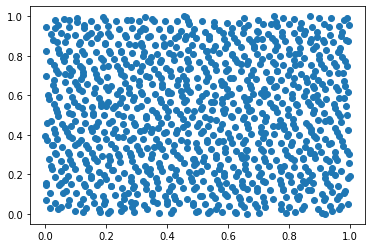

In [ ]:
import matplotlib.pyplot as plt

data = []
for i in range(1000):
  l = jitteredR2(i)
  data.append(np.array((l[0],l[1])))
#print(data)
data = np.rot90(data, 1) # y = 0, x = 1
#print(data)
plt.plot(data[1], data[0], 'o')
plt.show()

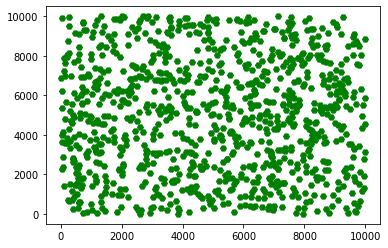

In [ ]:
import matplotlib.pyplot as plt
x = []
y = []
random.seed(int(time.time()))
for i in range(1000):
  x.append(random.uniform(0., 10000.))
  y.append(random.uniform(0., 10000.))
plt.plot(x, y, 'H', color='g')
plt.show()

In [2]:
def normire(data, entry_min, entry_max):
  entry_range = entry_max - entry_min
  norm_data = [0.0 + (data[i] - entry_min) / entry_range for i in range(len(data))]
  return norm_data

def renormire(norm_data, entry_min, entry_max):
  entry_range = entry_max - entry_min
  data = [entry_min + (norm_data[i] - 0.0) * entry_range for i in range(len(norm_data))]
  return data

In [3]:
''' Класс автоэнкодеров '''
class AutoencoderClass():
  def __init__(self, func, input_dim : int, encoding_dim : int, activations : list, enc_type : str):
    self.func = func                 # Функция обучения
    self.batch = 0
    self.input_dim = input_dim       # Размерность входного представления
    self.encoding_dim = encoding_dim # Размерность кодированного представления
    self.activations = activations   # Функции активации
    self.enc_type = enc_type         # Тип автоэнкодера
    self.aes_types = {'dense': self.__create_dense_ae,
                      'deep':  self.__create_deep_dense_ae,
                      'conv':  self.__create_deep_conv_ae,
                      'vae':   self.__create_vae}
    try:
      # Сборка моделей
      self.encoder, self.decoder, self.autoencoder = self.aes_types[self.enc_type]()
      self.autoencoder.compile(optimizer = 'adam', loss = self.custom_loss, metrics=['accuracy'])
    except KeyError as e:
      raise ValueError('Undefined unit: {}'.format(e.args[0]))

  # Обучение модели
  def fit(self, train_data, test_data, epochs : int, batch_size : int, shuffle : bool):
    self.batch = batch_size
    if self.enc_type != 'conv':
      self.autoencoder.fit(train_data, train_data,
                           epochs=epochs,
                           batch_size=self.batch,
                           shuffle=shuffle,
                           validation_data=(test_data, test_data))
    else:
      grid_train = []
      grid_test = []
      for i in range(len(train_data)):
        xx, yy = np.meshgrid(train_data[i], train_data[i])
        grid_train.append(xx)

      for i in range(len(test_data)):
        xx, yy = np.meshgrid(test_data[i], test_data[i])
        grid_test.append(xx)
      
      self.autoencoder.fit(grid_train, grid_train,
                           epochs=epochs,
                           batch_size=self.batch,
                           shuffle=shuffle,
                           validation_data=(grid_test, grid_test))

  # Предсказание результата
  def predict(self, x_vector):
    if self.enc_type != 'conv':
      return self.autoencoder.predict(x_vector)
    else:
      return self.autoencoder.predict(x_vector)[0]

  # Тип автоэнкодера
  def get_aec_type(self):
    return self.enc_type

  # Возвращает собранные модели
  def get_models(self):
    return self.autoencoder, self.encoder, self.decoder

  # Loss функция 
  def custom_loss(self, x_true, x_pred):
    return K.mean(K.square(self.func(x_pred) - self.func(x_true)))

  ''' Сжимающий автоэнкодер '''
  def __create_dense_ae(self):
    # Энкодер
    input_data = Input(shape=(self.input_dim))
    encoded = Dense(self.encoding_dim, activation = self.activations[0])(input_data)
    
    # Декодер
    input_encoded = Input(shape = (self.encoding_dim))
    decoded = Dense(self.input_dim, activation = self.activations[1])(input_encoded)

    # Модели
    encoder = Model(input_data, encoded, name = "encoder")
    decoder = Model(input_encoded, decoded, name = "decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name = "autoencoder")
    return encoder, decoder, autoencoder

  ''' Глубокий автоэнкодер '''
  def __create_deep_dense_ae(self):
    # Энкодер
    input_data = Input(shape=(self.input_dim))
    ############# Здесь фиксить надо с размерностями слоёв и как подавать активации на вход##########
    x = Dense(self.encoding_dim*3, activation='relu')(input_data)
    x = Dense(self.encoding_dim*2, activation='relu')(x)
    encoded = Dense(self.encoding_dim, activation='linear')(x)
    
    # Декодер
    input_encoded = Input(shape=(self.encoding_dim,))
    ############# Здесь фиксить надо с размерностями слоёв ##########
    x = Dense(self.encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(self.encoding_dim*3, activation='relu')(x)
    decoded = Dense(self.input_dim, activation='sigmoid')(x)
    
    # Модели
    encoder = Model(input_data, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name="autoencoder")
    return encoder, decoder, autoencoder

  ''' Сверточный автоэнкодер '''
  def __create_deep_conv_ae(self):
    # Энкодер
    input_data = Input(shape=(self.input_dim, self.input_dim, 1))
    x = Conv2D(25, (2, 2), activation='relu', padding='same')(input_data)
    x = MaxPooling2D((2, 2), padding='same')(x)
    #x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    #x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (2, 2), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное
    
    # Декодер
    input_encoded = Input(shape=(7, 7, 1))
    #x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(25, (2, 2), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_data, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name="autoencoder")
    return encoder, decoder, autoencoder

  ''' Вариационный автоэнкодер                         '''
  ''' Работает на основе девергенции Кульбака-Лейблера '''
  ''' Идея: переход данных скрытого слоя к нормальному распределению'''
  ''' Статья: https://habr.com/ru/post/484756/ '''
  ''' Видео:  https://youtu.be/ebI3JLAcWqQ '''
  def __create_vae(self):
    hidden_dim = 2
    
    # Выключение нейронов во избежании переобучения
    def dropout_and_batch(x):
      return Dropout(0.3)(BatchNormalization()(x))

    input_data = Input(shape=(self.input_dim))
    x = Dense(self.encoding_dim, activation='relu')(input_data)
    x = dropout_and_batch(x)
    #x = Dense(128, activation='relu')(x)
    #x = dropout_and_batch(x)
    
    z_mean = Dense(self.encoding_dim)(x)    # Мат ожидание
    z_log_var = Dense(self.encoding_dim)(x) # Логарифм дисперсии
    
    # Нормальное распределение N(0, 1)
    def noiser(args):
      global z_mean, z_log_var
      z_mean, z_log_var = args
      N = K.random_normal(shape=(self.batch, self.encoding_dim), mean=0., stddev=1.0)
      return K.exp(z_log_var / 2) * N + z_mean
    
    # Преобразование данных в нормальное распределения
    h = Lambda(noiser, output_shape=(self.encoding_dim))([z_mean, z_log_var])
    
    input_encoded = Input(shape=(self.encoding_dim))
    d = Dense(self.encoding_dim, activation='relu')(input_encoded)
    d = dropout_and_batch(d)
    #d = Dense(256, activation='relu')(d)
    #d = dropout_and_batch(d)
    decoded = Dense(self.input_dim, activation='sigmoid')(d)
    
    encoder = Model(input_data, h, name='encoder')
    decoder = Model(input_encoded, decoded, name='decoder')
    vae = Model(input_data, decoder(encoder(input_data)), name="vae")
    return encoder, decoder, vae

In [4]:
def generator_test(func, file_name, n = 10000):
  arr = []
  random.seed(int(time.time()))
  for i in range(n):
    x1 = random.uniform(0., 100.)
    x2 = random.uniform(0., 100.)
    x3 = random.uniform(0., 100.)
    x4 = random.uniform(0., 100.)
    arr.append([x1, x2, x3, x4, 0, 0])
  df = pd.DataFrame(arr, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
  df.to_csv('/content/sample_data/' + file_name)

In [5]:
def func(x):
  return x[0]*x[1] + x[1]*x[2] + x[3]*x[3]

n = 30000
generator_test(func, 'lin.csv', n)
#data = pd.read_csv('/content/sample_data/lin.csv', index_col=0).to_numpy('float32')

In [7]:
data = pd.read_csv('/content/sample_data/lin.csv', index_col=0).to_numpy('float32')
entry_min = 0.
entry_max = 100.
norm_data = normire(data, entry_min, entry_max)
#data_train, data_test, _, _ = train_test_split(norm_data, norm_data, train_size = 0.8, random_state = 42)
data_train = np.array(norm_data[0:int(n * 0.8)])
data_test = np.array(norm_data[n - int(n * 0.8):n])

In [12]:
''' Sobol '''
norm_data = sobol_seq.i4_sobol_generate(4, 20000)
norm_data = np.insert(norm_data, obj=4, values=[[0],[0]], axis=1)
data_train = np.array(norm_data[0:int(n * 0.8)])
data_test = np.array(norm_data[n - int(n * 0.8):n])

In [13]:
model = AutoencoderClass(func, 6, 4, list(['relu', 'sigmoid']), 'vae')
model.fit(data_train, data_test, 20, 10, True)

Epoch 1/20
2000/2000 [==============================] - 8s 3ms/step - loss: 0.2270 - accuracy: 0.2546 - val_loss: 0.0953 - val_accuracy: 0.3324
Epoch 2/20
2000/2000 [==============================] - 7s 3ms/step - loss: 0.1524 - accuracy: 0.3274 - val_loss: 0.0874 - val_accuracy: 0.4294
Epoch 3/20
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1423 - accuracy: 0.3819 - val_loss: 0.0688 - val_accuracy: 0.4740
Epoch 4/20
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1341 - accuracy: 0.4093 - val_loss: 0.0592 - val_accuracy: 0.5711
Epoch 5/20
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1272 - accuracy: 0.4488 - val_loss: 0.0569 - val_accuracy: 0.6356
Epoch 6/20
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1244 - accuracy: 0.4699 - val_loss: 0.0516 - val_accuracy: 0.6669
Epoch 7/20
2000/2000 [==============================] - 7s 3ms/step - loss: 0.1203 - accuracy: 0.4807 - val_loss: 0.0471 - val_accuracy:

In [14]:
data_predict = []
res_orig = []
res_pred = []
k = 10
for i in range(k):
  res_orig.append(func(data[i]))
  print(f'Orig X: {data[-1]}')
  print(f'Orig Y: {res_orig[-1]}')
  pred = model.decoder.predict(model.encoder.predict(norm_data[i].reshape(1,6), batch_size=32))
  data_predict.append(renormire(pred[0], entry_min, entry_max))
  res_pred.append(func(data_predict[-1]))
  print(f'Pred X: {data_predict[-1]}')
  print(f'Pred Y: {res_pred[-1]}\n')

print(f'X error: {mean_squared_error(data[0:k], data_predict)}')
print(f'Y error: {mean_squared_error(res_orig, res_pred)}')

Orig X: [16.182678  84.399864  11.531876   7.7193108  0.         0.       ]
Orig Y: 13196.294921875
Pred X: [51.04609727859497, 52.33367681503296, 52.646803855895996, 52.90616750717163, 0.4482567310333252, 0.4523545503616333]
Pred Y: 8225.693336282518

Orig X: [16.182678  84.399864  11.531876   7.7193108  0.         0.       ]
Orig Y: 7456.3544921875
Pred X: [68.0147647857666, 37.55217492580414, 50.12248158454895, 38.0485475063324, 0.44107139110565186, 0.44449567794799805]
Pred Y: 5884.002508292543

Orig X: [16.182678  84.399864  11.531876   7.7193108  0.         0.       ]
Orig Y: 12761.576171875
Pred X: [34.37189757823944, 66.52395725250244, 54.984670877456665, 65.13359546661377, 0.4544675350189209, 0.4591822624206543]
Pred Y: 10186.737798585526

Orig X: [16.182678  84.399864  11.531876   7.7193108  0.         0.       ]
Orig Y: 10342.263671875
Pred X: [38.391053676605225, 45.553308725357056, 51.044028997421265, 28.98542881011963, 0.42054057121276855, 0.4235506057739258]
Pred Y: 4914